In [1]:
from PIL import Image
import numpy as np
import os
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import cv2 
import random
from math import log
import time
print(cv2.__version__)
# Implementación en CPU, Nota la versión de GPU esta mas Abajo

4.0.1


In [10]:
def getImageMatrix(imageName):
    im = Image.open(imageName) 
    pix = im.load()
    color = 1
    if type(pix[0,0]) == int:
      color = 0
    image_size = im.size 
    image_matrix = []
    for width in range(int(image_size[0])):
        row = []
        for height in range(int(image_size[1])):
                row.append((pix[width,height]))
        image_matrix.append(row)
    return image_matrix,image_size[0],color

In [3]:
def dec(bitSequence):
    decimal = 0
    for bit in bitSequence:
        decimal = decimal * 2 + int(bit)
    return decimal

In [4]:
def genHenonMap(dimension, key):
    x = key[0]
    y = key[1]
    sequenceSize = dimension * dimension * 8 #Total Number of bitSequence produced
    bitSequence = []    #Each bitSequence contains 8 bits
    byteArray = []      #Each byteArray contains m( i.e 512 in this case) bitSequence
    TImageMatrix = []   #Each TImageMatrix contains m*n byteArray( i.e 512 byteArray in this case)
    for i in range(sequenceSize):
        xN = y + 1 - 1.4 * x**2
        yN = 0.3 * x

        x = xN
        y = yN

        if xN <= 0.4:
            bit = 0
        else:
            bit = 1

        try:
            bitSequence.append(bit)
        except:
            bitSequence = [bit]

        if i % 8 == 7:
            decimal = dec(bitSequence)
            try:
                byteArray.append(decimal)
            except:
                byteArray = [decimal]
            bitSequence = []

        byteArraySize = dimension*8
        if i % byteArraySize == byteArraySize-1:
            try:
                TImageMatrix.append(byteArray)
            except:
                TImageMatrix = [byteArray]
            byteArray = []
    return TImageMatrix

In [23]:
def HenonEncryption(imageName,key):
    imageMatrix, dimension, color = getImageMatrix(imageName)
    transformationMatrix = genHenonMap(dimension, key)
    resultantMatrix = []
    start_time = time.time()
    for i in range(dimension):
        row = []
        for j in range(dimension):
            try:
                if color:
                    row.append(tuple([transformationMatrix[i][j] ^ x for x in imageMatrix[i][j]]))
                else:
                    row.append(transformationMatrix[i][j] ^ imageMatrix[i][j])
            except:
                if color:
                    row = [tuple([transformationMatrix[i][j] ^ x for x in imageMatrix[i][j]])]
                else :
                    row = [transformationMatrix[i][j] ^ x for x in imageMatrix[i][j]]
        try:    
            resultantMatrix.append(row)
        except:
            resultantMatrix = [row]
    print("--- %s seconds ---" % (time.time() - start_time))
    if color:
      im = Image.new("RGB", (dimension, dimension))
    else: 
      im = Image.new("L", (dimension, dimension)) # L is for Black and white pixels

    pix = im.load()
    for x in range(dimension):
        for y in range(dimension):
            pix[x, y] = resultantMatrix[x][y]
    im.save(imageName.split('.')[0] + "_HenonEncCPU.png", "PNG")

In [24]:
def HenonDecryption(imageNameEnc, key):
    imageMatrix, dimension, color = getImageMatrix(imageNameEnc)
    transformationMatrix = genHenonMap(dimension, key)
    pil_im = Image.open(imageNameEnc, 'r')
    imshow(np.asarray(pil_im))
    henonDecryptedImage = []
    start_time = time.time()
    for i in range(dimension):
        row = []
        for j in range(dimension):
            try:
                if color:
                    row.append(tuple([transformationMatrix[i][j] ^ x for x in imageMatrix[i][j]]))
                else:
                    row.append(transformationMatrix[i][j] ^ imageMatrix[i][j])
            except:
                if color:
                    row = [tuple([transformationMatrix[i][j] ^ x for x in imageMatrix[i][j]])]
                else :
                    row = [transformationMatrix[i][j] ^ x for x in imageMatrix[i][j]]
        try:
            henonDecryptedImage.append(row)
        except:
            henonDecryptedImage = [row]
    print("--- %s seconds ---" % (time.time() - start_time))
    if color:
        im = Image.new("RGB", (dimension, dimension))
    else: 
        im = Image.new("L", (dimension, dimension)) # L is for Black and white pixels

    pix = im.load()
    for x in range(dimension):
        for y in range(dimension):
            pix[x, y] = henonDecryptedImage[x][y]
    im.save(imageNameEnc.split('_')[0] + "_HenonDecCPU.png", "PNG")

In [25]:
image = "400"
ext = ".jpg"
key = (0.1,0.1)

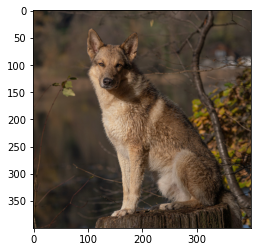

In [17]:
pil_im = Image.open(image + ext, 'r')
imshow(np.asarray(pil_im))

--- 0.14414072036743164 seconds ---
--- 1.1564979553222656 seconds ---


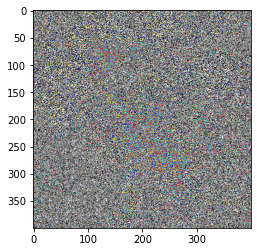

In [27]:
start_time = time.time()
HenonEncryption(image + ext, key)
print("--- %s seconds ---" % (time.time() - start_time))
im = Image.open(image + "_HenonEncCPU.png", 'r')
imshow(np.asarray(im))

--- 0.13802289962768555 seconds ---


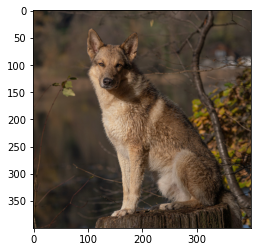

In [28]:
HenonDecryption(image + "_HenonEncCPU.png", key)
im = Image.open(image + "_HenonDecCPU.png", 'r')
imshow(np.asarray(im))

In [29]:
# Implementación a GPU
from numba import cuda
import math
import numpy as np
import cv2 
import time
print(cuda.gpus)

<Managed Device 0>


In [30]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Mon_Sep_13_20:11:50_Pacific_Daylight_Time_2021
Cuda compilation tools, release 11.5, V11.5.50
Build cuda_11.5.r11.5/compiler.30411180_0


In [31]:
gpu = cuda.get_current_device()
print("name = %s" % gpu.name)
print("maxThreadsPerBlock = %s" % str(gpu.MAX_THREADS_PER_BLOCK))
print("maxBlockDimX = %s" % str(gpu.MAX_BLOCK_DIM_X))
print("maxBlockDimY = %s" % str(gpu.MAX_BLOCK_DIM_Y))
print("maxBlockDimZ = %s" % str(gpu.MAX_BLOCK_DIM_Z))
print("maxGridDimX = %s" % str(gpu.MAX_GRID_DIM_X))
print("maxGridDimY = %s" % str(gpu.MAX_GRID_DIM_Y))
print("maxGridDimZ = %s" % str(gpu.MAX_GRID_DIM_Z))
print("maxSharedMemoryPerBlock = %s" % str(gpu.MAX_SHARED_MEMORY_PER_BLOCK))
print("asyncEngineCount = %s" % str(gpu.ASYNC_ENGINE_COUNT))
print("canMapHostMemory = %s" % str(gpu.CAN_MAP_HOST_MEMORY))
print("multiProcessorCount = %s" % str(gpu.MULTIPROCESSOR_COUNT))
print("warpSize = %s" % str(gpu.WARP_SIZE))
print("unifiedAddressing = %s" % str(gpu.UNIFIED_ADDRESSING))
print("pciBusID = %s" % str(gpu.PCI_BUS_ID))
print("pciDeviceID = %s" % str(gpu.PCI_DEVICE_ID))

name = b'NVIDIA GeForce GTX 1050 Ti'
maxThreadsPerBlock = 1024
maxBlockDimX = 1024
maxBlockDimY = 1024
maxBlockDimZ = 64
maxGridDimX = 2147483647
maxGridDimY = 65535
maxGridDimZ = 65535
maxSharedMemoryPerBlock = 49152
asyncEngineCount = 1
canMapHostMemory = 1
multiProcessorCount = 6
warpSize = 32
unifiedAddressing = 1
pciBusID = 1
pciDeviceID = 0


In [32]:
"""This lines encrypts the image using CUDA and henon cat map"""
# @cuda.jit
# @jit(forceobj=True)
@cuda.jit
def HenonDecryptionCUDA(imageMatrix,transformationMatrix,resultantMatrix):
    i, j = cuda.grid(2)
    if i < resultantMatrix.shape[0] and j < resultantMatrix.shape[1]:
        resultantMatrix[i][j] = transformationMatrix[i][j] ^ imageMatrix[i][j]

In [43]:
image = "3840"
ext = ".jpg"
imageName = image+ext
key = (0.1,0.1)
imageMatrix = cv2.imread(imageName, 0)
dimension =imageMatrix.shape[0]
resultantMatrix = np.zeros((dimension,dimension))
transformationMatrix = genHenonMap(dimension, key)
an_array = resultantMatrix
threadsperblock = (512, 2)
blockspergrid_x = math.ceil(an_array.shape[0] / threadsperblock[0])
blockspergrid_y = math.ceil(an_array.shape[1] / threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y) 
transformationMatrix =  np.array(transformationMatrix)



--- 0.30219268798828125 seconds ---


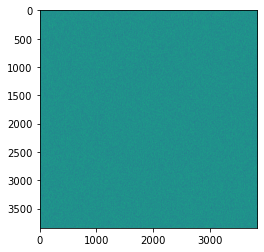

In [44]:
start_time = time.time()
HenonDecryptionCUDA[blockspergrid, threadsperblock](imageMatrix,transformationMatrix,resultantMatrix)
print("--- %s seconds ---" % (time.time() - start_time))

cv2.imwrite('3840EncGPU.png', resultantMatrix)
im = Image.open("3840EncGPU.png", 'r')
imshow(np.asarray(im))

In [38]:
@cuda.jit
def HenonDecryptionCUDA(imageMatrix, transformationMatrix,henonDecryptedImage):
    i, j = cuda.grid(2)
    if i < henonDecryptedImage.shape[0] and j < henonDecryptedImage.shape[1]:
        henonDecryptedImage[i][j] = transformationMatrix[i][j] ^ imageMatrix[i][j]

--- 0.2214064598083496 seconds ---


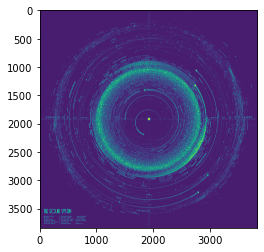

In [45]:
imageMatrix = cv2.imread('3840EncGPU.png', 0)
dimension =imageMatrix.shape[0]
resultantMatrix = np.zeros((dimension,dimension))

an_array = resultantMatrix
threadsperblock = (512, 2)
blockspergrid_x = math.ceil(an_array.shape[0] / threadsperblock[0])
blockspergrid_y = math.ceil(an_array.shape[1] / threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y) 

transformationMatrix =  np.array(transformationMatrix)
start_time = time.time()
HenonDecryptionCUDA[blockspergrid, threadsperblock](imageMatrix,transformationMatrix,resultantMatrix)
print("--- %s seconds ---" % (time.time() - start_time))

cv2.imwrite('original.png', resultantMatrix)
im = Image.open("original.png", 'r')
imshow(np.asarray(im))